# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

## 0. Install the prerequisites
---

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.17 which is incompatible.


## 1. Defining Agent, Env, Training Process
------

### Defining a Q Network

A Q network that will approximate the state-action value function 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt

from unityagents import UnityEnvironment
import numpy as np

In [3]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=74, fc2_units=74):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


### Defining the Agent

In [4]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def get_action(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

#         print("next_state shapes: ", next_states.shape)

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        ## gether() gets the actions according to given indexes, more here https://stackoverflow.com/a/54706716/6054066
        ## effectively Q_expected will have the expected reward value of each state-action pair
        Q_expected = self.qnetwork_local(states).gather(1, actions) 

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



cuda:0


### Defining a ReplayBuffer (to store memories to)

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Defining the network training process
0. Define the monitoring of the process
1. Define first one episode
2. Define a training loop for multiple episodes
3. Define a testing loop for a single episode with no training

In [6]:
def monitor(i_episode, scores_window, score_batch):
    if i_episode % score_batch == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

In [7]:
def one_episode(env, agent, brain_name, max_t=10, eps = 1.0):
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    for t in range(max_t):
        action = dqn_agent.get_action(state, eps)           # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        dqn_agent.step(state, action, reward, next_state, done)
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            return score
    else:
        return score

In [8]:
def run_training(env, agent, brain_name, score_batch = 100, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, ):
    scores = []
    scores_window = deque(maxlen=score_batch)
    eps = eps_start

    for i_episode in range(1, n_episodes+1):
        score = one_episode(env, agent, brain_name, max_t, eps)
        
        scores.append(score)
        scores_window.append(score)
        monitor(i_episode, scores_window, score_batch)
        
        eps = max(eps_end, eps_decay*eps)

    return scores

In [ ]:
def one_episode_test(env, agent, brain_name, max_t=10):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    for t in range(max_t):
        action = dqn_agent.get_action(state, eps)           # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            return score
    else:
        return score

## 2. Creating Agent, Environment, then Training the network and plotting it
--------

### Creating the environment and training the network

In [9]:
def create_env(file_name):
    # please do not modify the line below
    env = UnityEnvironment(file_name=file_name)

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents in the environment
    print('Number of agents:', len(env_info.agents))

    # number of actions
    action_size = brain.vector_action_space_size
    print('Number of actions:', action_size)

    # examine the state space 
    state = env_info.vector_observations[0]
    print('States look like:', state)
    state_size = len(state)
    print('States have length:', state_size)
    
    return env, state_size, action_size, brain_name

In [10]:
env, state_size, action_size, brain_name = create_env("/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### Check how long an episode terminates

In [12]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
num_term_steps=0
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    num_term_steps+=1
    if done:                                       # exit loop if episode finished
        break
print("Max steps: ", num_term_steps)


Max steps:  300
Score: 0.0


## 3. Training the agent with the base DQN Network
---

### Create the agent, train it and save the trained network into a .pth file that can be loaded later.

In [13]:
seed = 0

dqn_agent = Agent(state_size, action_size, seed)

score_batch = 100
n_episodes=2000
max_t=300

scores = run_training(env, dqn_agent, brain_name, score_batch = score_batch, n_episodes= n_episodes, max_t=max_t)

name = "checkpoint_" + str(score_batch) + "_"+str(n_episodes) + "_" + str(max_t) + "_dqn_base.pth" 
torch.save(dqn_agent.qnetwork_local.state_dict(), name)

Episode 2000	Average Score: 14.99

### Plot the network performance

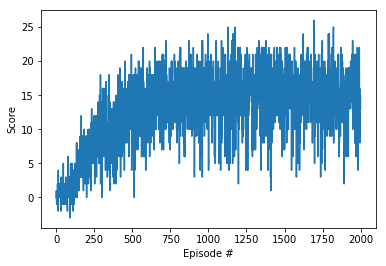

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch the trained agent interact

In [ ]:
score = one_episode_test(env, dqn_agent, brain_name, 300)
print(score)

## 4. Train a DQN Agent with Prioritized Learning
---

### Define a new Replay Buffer with Prioritized Replay sampling

In [11]:
class PL_ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, e=0.01, a=0.70, beta=0.4):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done", "priority"])
        self.seed = random.seed(seed)
        
        self.e = e
        self.a = a
        self.beta = beta
    
    def add(self, state, action, reward, next_state, done, error):
        """Add a new experience to memory."""
        priority = self.get_priority(error)
        e = self.experience(state, action, reward, next_state, done, priority)
        self.memory.append(e)
        
    def update(self, errors, ids):
        for ii, _id in enumerate(ids):
            state, action, reward, next_state, done, priority = self.memory[_id]
            new_priority = self.get_priority(errors[ii])[0]
            e = self.experience(state, action, reward, next_state, done, new_priority)
            self.memory[_id] = e
        
        
    def get_priority(self, error):
        return (abs(error) + self.e) ** self.a
        
    
    def sample(self):
        """Sample a batch of experiences from memory according to their normalized errors -> probabilities."""
        priorities = np.array([e.priority for e in self.memory if e is not None])
        sum_errors = np.array(np.sum(priorities))
        probabilities = priorities/sum_errors

        # Select experiences according to probabilities
        weighted_random_indices = np.random.choice(len(probabilities), size=self.batch_size, p=probabilities)
        experiences = [self.memory[i] for i in weighted_random_indices]
        probabilities_of_chosen = np.array([probabilities[i] for i in weighted_random_indices])

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        
        imp_samp = torch.from_numpy(np.power(((1/len(self.memory)) * (1/probabilities_of_chosen)), self.beta)).float().to(device)
        
        return (states, actions, rewards, next_states, dones), imp_samp, weighted_random_indices

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Define a new agent which uses Prioritized Replay buffer and Imprtance Sampling

In [12]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class PL_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = PL_ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    

    def get_action(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        experience=(state, action, reward, next_state, done)
        
#         error = self.calc_Q_targets(experience, GAMMA)
        error = 0.0
        self.memory.add(state, action, reward, next_state, done, error)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences, imp_samp, ids = self.memory.sample()
                self.learn(experiences, imp_samp, ids, GAMMA)

#     def calc_Q_targets(self, experience, gamma):
#         state, action, reward, next_state, done = experience

#         conv_state = torch.from_numpy(state).float().unsqueeze(0).to(device)
#         conv_next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
#         # Get max predicted Q values (for next states) from target model
#         Q_targets_next = self.qnetwork_target(conv_next_state).detach().max(1)[0].unsqueeze(1)
    
#         # Compute Q targets for current states 
#         Q_targets_target = reward + (gamma * Q_targets_next * (1 - done))
#         Q_target_expected = self.qnetwork_target(conv_state).detach().max(1)[0].unsqueeze(1)
        
#         error = Q_targets_target - Q_target_expected
        
#         return error
    
        
    def learn(self, experiences, imp_samp, ids, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions) 

        # calculate TD Errors and update priority
        errors = Q_expected - Q_targets
        self.memory.update(errors.cpu().detach().numpy(), ids)
    
        # Compute loss
#         print("IMP SAMP")
#         print("shape: ", imp_samp.shape)
#         print(imp_samp)
        
#         print("IDS")
#         print("shape: ", ids.shape)
#         print(ids)
        
#         print("MSE LOSS")
        mse_loss = F.mse_loss(Q_expected, Q_targets, reduce =False).view(-1)
#         print("shape: ", mse_loss.shape)
#         print(mse_loss)
        
#         print("Simple loss")
        delta_w = imp_samp * mse_loss
#         print(delta_w)
        
        loss = torch.sum(delta_w)
        
#         print("LOSS Mean")
#         print(loss)
        
#         print("==============")
#         print("==============")

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()               

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



cuda:0


### Create agent and run training with Prioritized Replay

In [ ]:
seed = 0

dqn_pl_agent = PL_Agent(state_size, action_size, seed)

score_batch = 100
n_episodes=2000
max_t=300
scores = run_training(env, dqn_pl_agent, brain_name, score_batch = score_batch, n_episodes=n_episodes, max_t=max_t)

name = "checkpoint_" + str(score_batch) + "_"+str(n_episodes) + "_" + str(max_t) + "_dqn_pl.pth" 
torch.save(dqn_agent.qnetwork_local.state_dict(), name)

Episode 300	Average Score: 0.24

### Plot the performance

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch the trained agent interact

In [ ]:
score = one_episode_test(env, dqn_pl_agent, brain_name, 300)
print(score)

## 5. End the session
---

In [ ]:
env.close()